#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

### Импорт используемых библиотек

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgb
import time

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    TimeSeriesSplit
)

from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
np.random.seed(42)  # Установка глобального random_state

### Чтение файла

In [4]:
try:
    df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=0)
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', parse_dates=[0], index_col=0)

Посмотрим на информацию

In [12]:
display(df.head())
display(df.describe())
display(df.shape)
print('Количество пропусков:', df.isna().sum())
df.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


(26496, 1)

Количество пропусков: num_orders    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим методом `is_monotonic()`, что индексы таблицы расположены в хронологическом порядке.

In [13]:
df.index.is_monotonic

True

- Датасет имеет 26496 строк
- Информация предоставлена за период с 2018-03-01 по 2018-08-31	с интервалом в 10 минут
- Пропуски отсутствуют
- Индексы таблицы расположены в хронологическом порядке

## Анализ

### Ресемплирование

Ресемплируем по часу и найдем сумму

In [14]:
df = df.resample('1H').sum()

In [15]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


### Графики

#### Скользящая средняя

In [16]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()

Создадим функцию, строющую график

In [17]:
def plot_df(df, xlabel='', ylabel=''):
    plt.figure(figsize=(15, 4))
    plt.rc('font', size=10)
    plt.plot(df)
    plt.grid()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

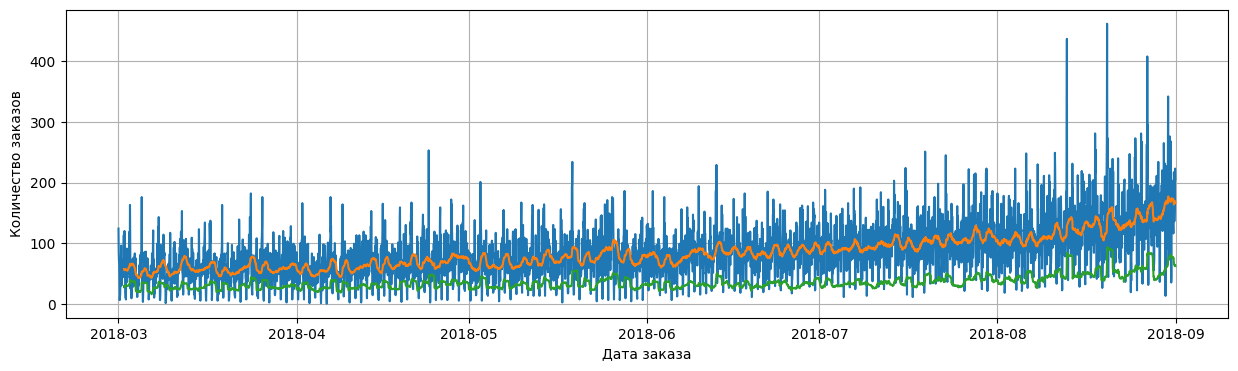

In [18]:
plot_df(df, 'Дата заказа', 'Количество заказов')

Скользящая средняя показывает, что тренд становится восходящим в летний период. В данном случае временной ряд нестационарный – количество заказов постепенно растет

Для определения стационарного ряда применяется тест Дики-Фуллера

In [19]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')

Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


Тест говорит, о том, что ряд стационарный. Чтобы было более это наглядно на графике, найдем разности временного ряда методом `shift()`.

In [20]:
df_copy = df.copy()

df_copy = df_copy - df_copy.shift()
df_copy['mean'] = df_copy['num_orders'].rolling(24).mean()
df_copy['std'] = df_copy['num_orders'].rolling(15).std()

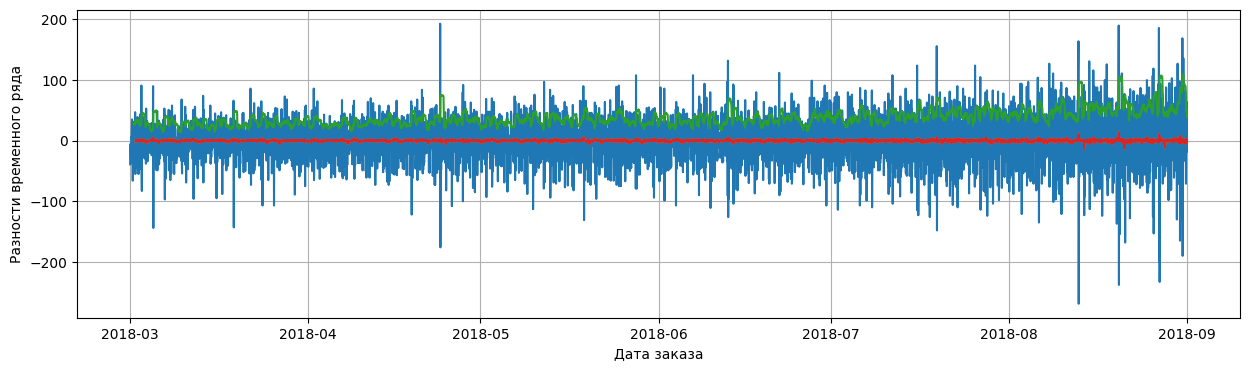

In [21]:
plot_df(df_copy, 'Дата заказа', 'Разности временного ряда')

Чтобы лучше понимать временной ряд, разберём тренды и сезонность.

In [22]:
decomposed = seasonal_decompose(df['num_orders'])

#### Тренд

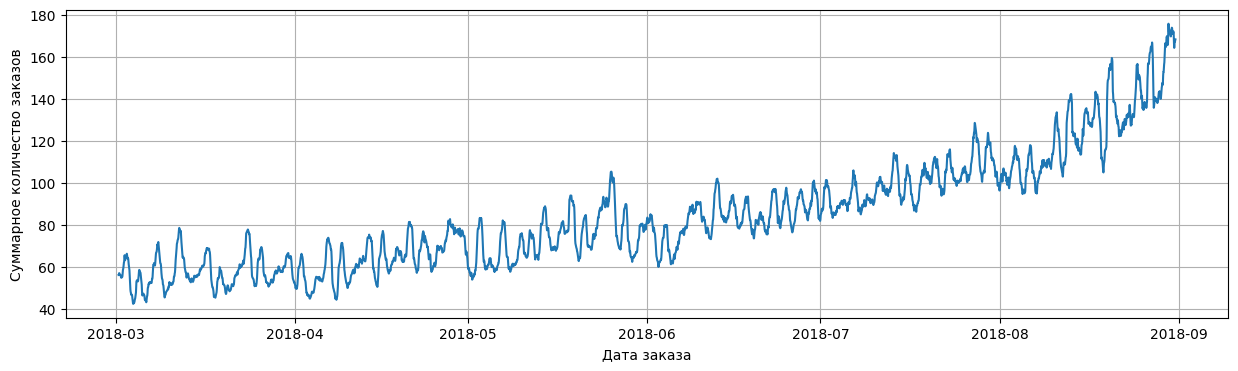

In [23]:
plot_df(decomposed.trend, 'Дата заказа', 'Суммарное количество заказов')

Тренд повторяет свое направление за скользящей средней

#### Сезоннность

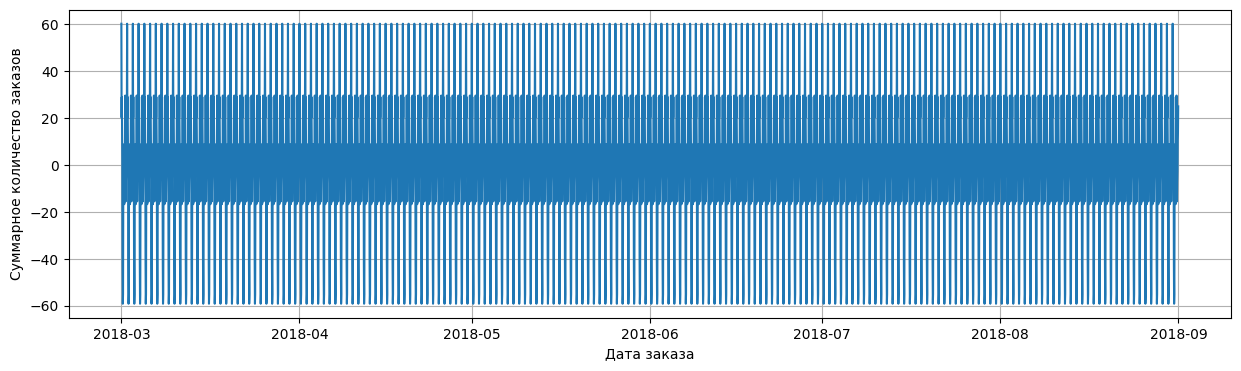

In [24]:
plot_df(decomposed.seasonal, 'Дата заказа', 'Суммарное количество заказов')

Невозможно понять сезонность, нужно изменить масштаб

Масштаб в разрезе недели

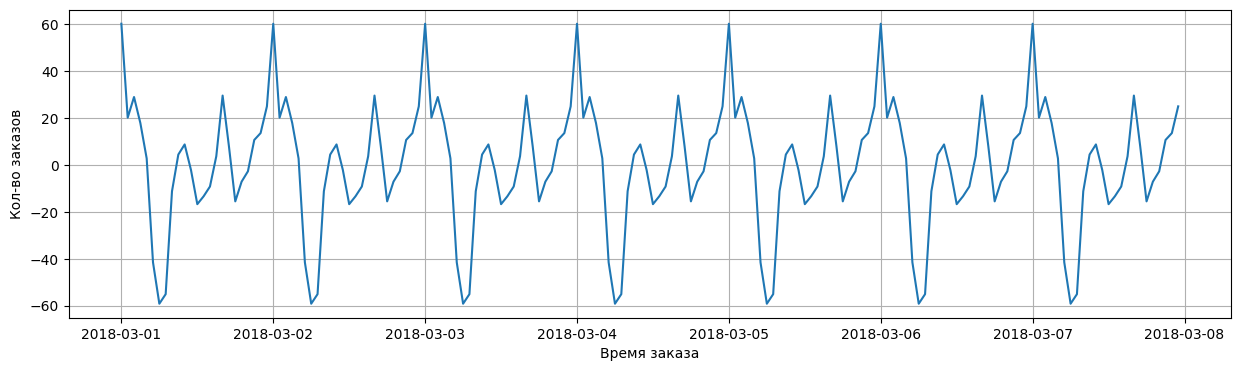

In [28]:
plot_df(decomposed.seasonal['2018-03-01':'2018-03-07'], 'Время заказа', 'Кол-во заказов')

Масштаб в разрезе суток

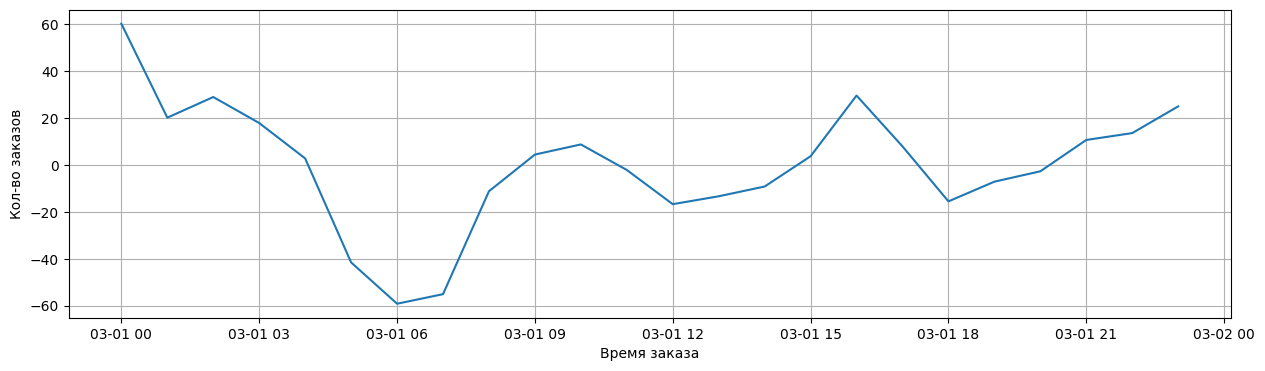

In [29]:
plot_df(decomposed.seasonal['2018-03-01'], 'Время заказа', 'Кол-во заказов')

#### Остаток декомпозиции

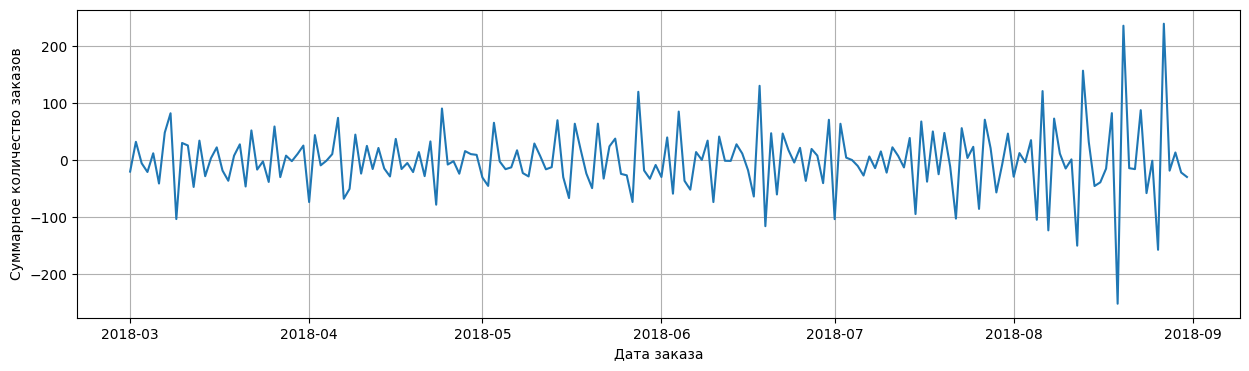

In [30]:
plot_df(decomposed.resid.resample('1D').sum(), 'Дата заказа', 'Суммарное количество заказов')

### Выводы

- Наблюдаем восходящий тренд по заказам (особенно виден он летом)
- Пиковое количество заказов в день приходится на полночь - `0:00`
- Меньше всего заказов происходит утром - `6:00`
- Доля остатков увеличивается в августе месяце - как раз во время ускорения тренда (*данные остатки могут создать большую разницу между метриками при обучении и исследовании*)

## Обучение

Напишем функцию make_features() (англ. «создать признаки»), чтобы прибавить к таблице четыре новых календарных признака: год, месяц, день и день недели.

In [35]:
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [36]:
make_features(df, 24, 24)

In [37]:
df.head()

,num_orders,rolling_mean,std,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобьем на выборки и удалим строки с пропусками

In [38]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.shape)
print(test.shape)

(3950, 30)
(442, 30)


Выделим признаки и целевой признак.

In [39]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
 
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Так как мы работаем с временнЫми данными, для которых порядок имеет значение, используем метод кросс-валидации `TimeSeriesSplit`.

In [40]:
tscv = TimeSeriesSplit(n_splits=5)

Создадим список обучаемых моделей с лучшими метриками RMSE

Напишем функцию перебора гиперпараметров способом `GridSearchCV` и обучения модели

In [48]:
model_list = pd.DataFrame(columns=['model', 'RMSE', 'Time'])

In [49]:
def model_learn(model, param_grid):
    
    grid_search = GridSearchCV(estimator=model,
                         param_grid=param_grid,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=-1)
    
    start_fit = time.time()
    grid_search.fit(features_train, target_train)
    end_fit = time.time()
    
    rmse = round(abs(grid_search.best_score_), 3)
    time_fit = round(end_fit - start_fit, 2)
        
    model_list.loc[len(model_list)] = [model, rmse, time_fit]
    
    
    
    print('Время обучения:', time_fit, 'сек.')
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучший RMSE:", rmse)

### LGBMRegressor

In [50]:
model_lgbm = LGBMRegressor(force_row_wise=True)

param_grid = {
    'n_estimators': [10, 100, 200, 300],
    'max_depth': [2, 10],
    'verbosity': [-1],
    'num_leaves': [3, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}

model_learn(model_lgbm, param_grid)

Время обучения: 6.26 сек.
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'num_leaves': 10, 'verbosity': -1}
Лучший RMSE: 24.18


### CatBoost

In [51]:
model_cbr = CatBoostRegressor(loss_function='RMSE')

param_grid = {
    'iterations': [100, 200, 301],
    'learning_rate': [0.01, 0.1, 0.2],
    'depth': [6, 8, 10],
    'verbose': [25]
}

model_learn(model_cbr, param_grid)

0:	learn: 36.6935619	total: 4.2ms	remaining: 1.26s
25:	learn: 23.2884513	total: 106ms	remaining: 1.13s
50:	learn: 21.9121160	total: 246ms	remaining: 1.21s
75:	learn: 20.7060469	total: 359ms	remaining: 1.06s
100:	learn: 19.6422640	total: 462ms	remaining: 914ms
125:	learn: 18.6773602	total: 556ms	remaining: 772ms
150:	learn: 17.6852935	total: 650ms	remaining: 646ms
175:	learn: 16.9497121	total: 743ms	remaining: 528ms
200:	learn: 16.2610883	total: 834ms	remaining: 415ms
225:	learn: 15.7110913	total: 914ms	remaining: 303ms
250:	learn: 15.1816329	total: 998ms	remaining: 199ms
275:	learn: 14.6355688	total: 1.09s	remaining: 99.2ms
300:	learn: 14.1149518	total: 1.2s	remaining: 0us
Время обучения: 306.07 сек.
Лучшие параметры: {'depth': 6, 'iterations': 301, 'learning_rate': 0.1, 'verbose': 25}
Лучший RMSE: 24.427


### Дерево решений

In [52]:
model_dcr = DecisionTreeRegressor()

param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model_learn(model_dcr, param_grid)

Время обучения: 1.1 сек.
Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}
Лучший RMSE: 29.505


### Вывод

In [53]:
model_list

,model,RMSE,Time
0,LGBMRegressor(force_row_wise=True),24.180,6.26
1,<catboost.core.CatBoostRegressor object at 0x0...,24.427,306.07
2,DecisionTreeRegressor(),29.505,1.10


Наилучшую метрику показала модель обученная CatBoost'ом

## Тестирование

Функция построения графика предсказаний и реальных данных

In [54]:
def make_plot(predict, rmse):
    plt.figure(figsize=(14, 4))
    plt.plot(predict, "r", label="Prediction")
    plt.plot(target_test.values, 'b', alpha=0.6, label="Real data")
    plt.legend(loc="best")
    plt.title("RMSE: {}".format(round(rmse, 2)))
    plt.grid(True)

### LGBMRegressor

In [55]:
model_lgbm = LGBMRegressor(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=100,
    num_leaves=10,
    verbosity=-1,
    force_row_wise=True)

model_lgbm.fit(features_train, target_train)

predict_lgbm = model_lgbm.predict(features_test)

rmse_lgbm = mean_squared_error(target_test, predict_lgbm, squared=False)

print(f'RMSE: {rmse_lgbm}')

RMSE: 42.602130914410566


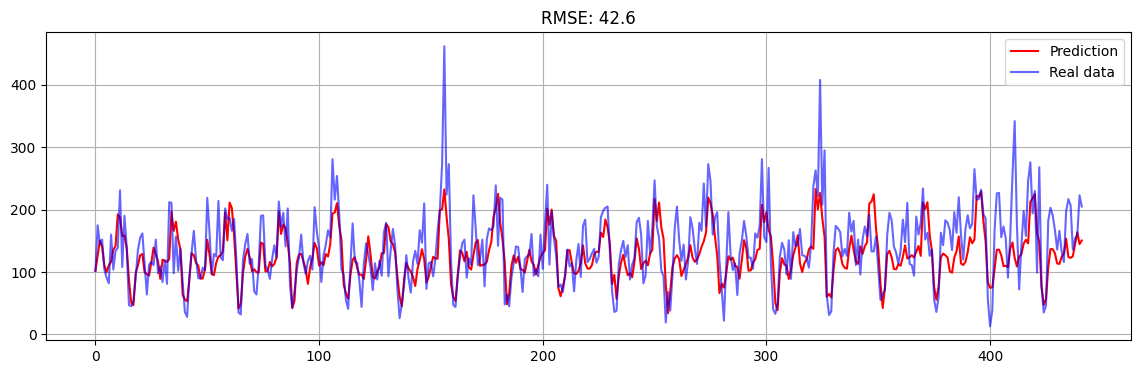

In [56]:
make_plot(predict_lgbm, rmse_lgbm)

### CatBoost

In [57]:
model_cb = CatBoostRegressor(loss_function='RMSE', depth=6, iterations=301, learning_rate=0.1, verbose=25)

model_cb.fit(features_train, target_train)

predict_cb = model_cb.predict(features_test)

rmse_cb = mean_squared_error(target_test, predict_cb, squared=False)

print(f'RMSE: {rmse_cb}')

0:	learn: 36.6935619	total: 3.83ms	remaining: 1.15s
25:	learn: 23.2884513	total: 76.2ms	remaining: 806ms
50:	learn: 21.9121160	total: 141ms	remaining: 693ms
75:	learn: 20.7060469	total: 220ms	remaining: 653ms
100:	learn: 19.6422640	total: 287ms	remaining: 569ms
125:	learn: 18.6773602	total: 353ms	remaining: 490ms
150:	learn: 17.6852935	total: 426ms	remaining: 423ms
175:	learn: 16.9497121	total: 496ms	remaining: 352ms
200:	learn: 16.2610883	total: 562ms	remaining: 280ms
225:	learn: 15.7110913	total: 630ms	remaining: 209ms
250:	learn: 15.1816329	total: 707ms	remaining: 141ms
275:	learn: 14.6355688	total: 773ms	remaining: 70.1ms
300:	learn: 14.1149518	total: 847ms	remaining: 0us
RMSE: 42.22528381969974


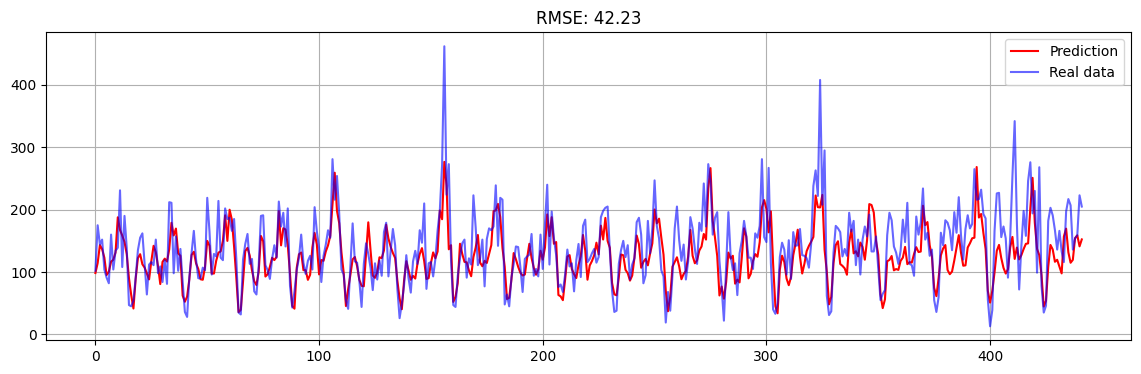

In [58]:
make_plot(predict_cb, rmse_cb)

### Дерево решений

In [59]:
model_dt = DecisionTreeRegressor(max_depth=5, min_samples_leaf=4, min_samples_split=10)

model_dt.fit(features_train, target_train)

predict_dt = model_dt.predict(features_test)

rmse_dt = mean_squared_error(target_test, predict_dt, squared=False)

print(f'RMSE: {rmse_dt}')

RMSE: 53.84385254996975


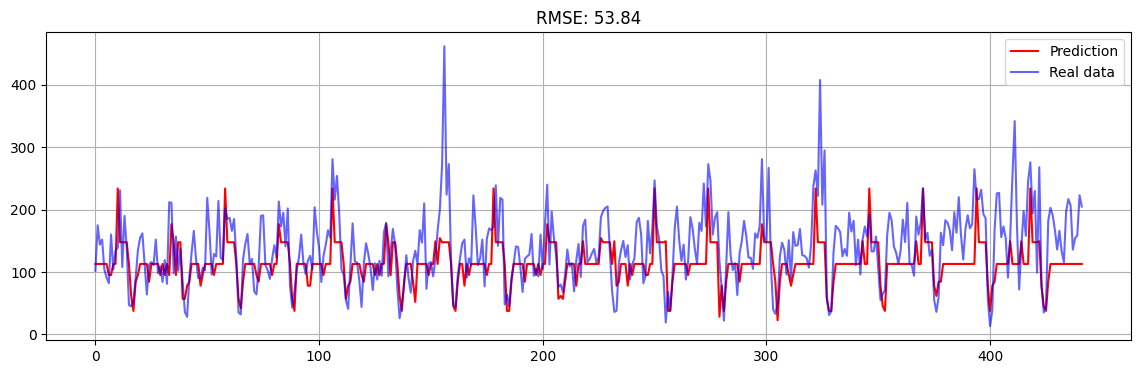

In [60]:
make_plot(predict_dt, rmse_dt)

### DummyRegressor

Предскажем следующее значение предыдущим в константной модели:

In [62]:
dummy_model_shift = DummyRegressor(strategy='mean')  # Выберите подходящую стратегию

# Обучаем модель
dummy_model_shift.fit(features_train, target_train)

pred_previous = target_test.shift()
pred_previous.iloc[0] = target_train.iloc[-1]

# Прогнозируем значения
#dummy_predictions = dummy_model.predict(features_test)

# Вычисляем RMSE для оценки качества модели
rmse_dummy = mean_squared_error(target_test, pred_previous, squared=False)
print(f"RMSE константной модели: {rmse_dummy}")

RMSE константной модели: 58.856486242815066


Метрика RMSE у константной модели больше, чем у LGB, CatBoost и Дерева решений

## Вывод:

- Все обученные модели (`LGBM`, `CatBoost`, `DecisionTree`) успешно прошли проверку на адекватность
- На тестовой выборке неудовлетворительный результат (RMSE > 48) показала модель `DecisionTree`
- Лучший результат показала модель `CatBoost` - RMSE равна **24.304**
- Быстрее всего обучилась модель `DecisionTree` - **1** секунда

Для прогнозирования количества заказов такси на следующий час следует использовать модель `LGBM`: она практически не уступает показавшей лучшую метрику RSME `CatBoost` (*24.625* против *ч*) и обучается намного быстрее, чем та же `CatBoost` (*10.39* против *266.18* секунд). Самая быстрая модель `DecisionTree` показала результаты хуже, поэтому ее не предлагаем.